In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

import utils.datasets as datasets
import utils.sde_lib as sdes
from utils.models import MLP
from utils.misc import dotdict, batch_matrix_product

torch.set_printoptions(precision=3,sci_mode=False)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = 1000
# covs = torch.tensor([[[3., -1.],[-1., 2.]], [[3., 1.8],[1.8, 2.]], [[3., -1.],[-1., 2.]]], device=device)
# means = torch.tensor([[0,3.], [10,5.], [-6.,0]],device=device)
# weights = torch.ones(means.shape[0],device=device)/means.shape[0]
# gmm = GMM(weights,means,covs)
dataset = datasets.get_dataset(dotdict({'dataset' : 'spiral'}))
data = dataset.sample(5).to(device=device)

sde = sdes.LinearSchrodingerBridge(2,device)
model = MLP(2,False).to(device=device)

eps = sde.delta
times = (torch.rand((data.shape[0]),device=data.device) * (1-eps) + eps) * sde.T()
shaped_t = times.reshape(-1,1,1,1) if len(data.shape) > 2 else times.reshape(-1,1)
# mean, L, invL, _ = sde.marginal_prob(data,shaped_t)
# noise = torch.randn_like(mean,device=data.device)
# perturbed_data = mean + torch.bmm(L, noise.unsqueeze(-1)).squeeze(-1)
# flatten_error = ((torch.bmm(invL.mT, noise.unsqueeze(-1)).squeeze(-1) + model(perturbed_data,times))**2).view(data.shape[0],-1)


# std = (1-torch.exp(-sde.beta_int(shaped_t)))**.5

# print(times)
# print((std).cpu().numpy())
# print(L[:,0,0].cpu().numpy())

# print(L)
# print(invL.mT)

# print(perturbed_data)
# print(torch.exp(-sde.beta_int(shaped_t)/2) * data + noise * std)

# print(torch.bmm(invL.mT, noise.unsqueeze(-1)).squeeze(-1))
# print(noise / std)

# plt.scatter(data[:,0], data[:,1])
# plt.show()


# print(-.5 * sde.beta(shaped_t) * perturbed_data)
# print(-.5 * sde.beta(shaped_t) * batch_matrix_product(sde.A(shaped_t),perturbed_data))
# print(sde.drift(perturbed_data,shaped_t))


tensor([[-0.847, -0.688],
        [-0.494,  0.738]], grad_fn=<ViewBackward0>)


In [3]:
t = shaped_t
int_mat = sde.int_beta_ds(t)
print(int_mat)
dim = int_mat.shape[-1]
C_H_power = torch.zeros((t.shape[0], 2 * dim, 2 * dim),device=int_mat.device)
C_H_pair = torch.zeros_like(C_H_power)
C_H_power[:,:dim, :dim] = -.5 * int_mat
C_H_power[:,-dim:, -dim:] = .5 * int_mat
C_H_power[:, :dim, dim:] = sde.beta_int(t).view(-1,1,1) * torch.eye(dim,device=int_mat.device).unsqueeze(0).expand(t.shape[0],-1,-1)


print(C_H_power)
C_H_pair = torch.linalg.matrix_exp(C_H_power)
initial_cond = torch.cat((torch.zeros((dim,dim), device=int_mat.device), torch.eye(dim,device=int_mat.device)), dim=0)
C_H = torch.einsum('tij,jk->tik', C_H_pair, initial_cond)
C = C_H[:, : dim, :]
H = C_H[:, dim: , :]
cov = torch.einsum('tij,tjk->tik', C, torch.linalg.inv(H))
L = torch.linalg.cholesky(cov)
invL = torch.linalg.inv(L.mH)
print(C_H_pair)

tensor([[[ 6.454,  3.476],
         [ 3.476, -2.872]],

        [[15.538,  8.368],
         [ 8.368, -6.914]],

        [[ 1.419,  0.764],
         [ 0.764, -0.632]],

        [[ 0.594,  0.320],
         [ 0.320, -0.264]],

        [[18.196,  9.800],
         [ 9.800, -8.097]]], device='cuda:0')
tensor([[[-3.227, -1.738,  1.475,  0.000],
         [-1.738,  1.436,  0.000,  1.475],
         [ 0.000,  0.000,  3.227,  1.738],
         [ 0.000,  0.000,  1.738, -1.436]],

        [[-7.769, -4.184,  3.550,  0.000],
         [-4.184,  3.457,  0.000,  3.550],
         [ 0.000,  0.000,  7.769,  4.184],
         [ 0.000,  0.000,  4.184, -3.457]],

        [[-0.710, -0.382,  0.324,  0.000],
         [-0.382,  0.316,  0.000,  0.324],
         [ 0.000,  0.000,  0.710,  0.382],
         [ 0.000,  0.000,  0.382, -0.316]],

        [[-0.297, -0.160,  0.136,  0.000],
         [-0.160,  0.132,  0.000,  0.136],
         [ 0.000,  0.000,  0.297,  0.160],
         [ 0.000,  0.000,  0.160, -0.132]],

       

In [4]:
ts = torch.linspace(.1,sde.T(), 6,device=device).unsqueeze(-1)
cov, L, invL, _ = sde.compute_variance(ts)
print(L)
print(invL)

tensor([[[ 0.219,  0.118],
         [ 0.118, -0.097]],

        [[ 1.716,  0.924],
         [ 0.924, -0.763]],

        [[ 4.630,  2.494],
         [ 2.494, -2.060]],

        [[ 8.963,  4.827],
         [ 4.827, -3.989]],

        [[14.714,  7.925],
         [ 7.925, -6.548]],

        [[21.883, 11.785],
         [11.785, -9.738]]], device='cuda:0')
tensor([[0.050],
        [0.392],
        [1.058],
        [2.048],
        [3.362],
        [5.000]], device='cuda:0')
tensor([[[ 0.219,  0.118],
         [ 0.118, -0.098]],

        [[ 1.720,  0.926],
         [ 0.926, -0.765]],

        [[ 4.643,  2.500],
         [ 2.500, -2.066]],

        [[ 8.987,  4.840],
         [ 4.840, -3.999]],

        [[14.753,  7.946],
         [ 7.946, -6.565]],

        [[21.941, 11.817],
         [11.817, -9.764]]], device='cuda:0')
tensor([[[ -0.110,  -0.059,   0.050,   0.000],
         [ -0.059,   0.049,   0.000,   0.050],
         [  0.000,   0.000,   0.110,   0.059],
         [  0.000,   0.000,   0.0

tensor([[ 0.068,  0.413],
        [ 0.893, -0.020]], grad_fn=<ViewBackward0>)
tensor([ 0.068,  0.413,  0.893, -0.020], device='cuda:0')
tensor([ 0.915,  0.823, -0.975,  0.320], device='cuda:0')
tensor([[[-13.265,   1.510],
         [  1.510,  -1.390]]], device='cuda:0')
tensor([[5.]], device='cuda:0')
tensor([[[-13.300,   1.514],
         [  1.514,  -1.394]]], device='cuda:0')
tensor([[[ 6.650, -0.757,  5.000,  0.000],
         [-0.757,  0.697,  0.000,  5.000],
         [ 0.000,  0.000, -6.650,  0.757],
         [ 0.000,  0.000,  0.757, -0.697]]], device='cuda:0')
tensor([[[   836.512,   -104.478,    310.131,    -38.155],
         [  -104.478,     14.904,    -38.155,     10.084],
         [     0.000,      0.000,      0.010,      0.067],
         [     0.000,      0.000,      0.067,      0.539]]], device='cuda:0')


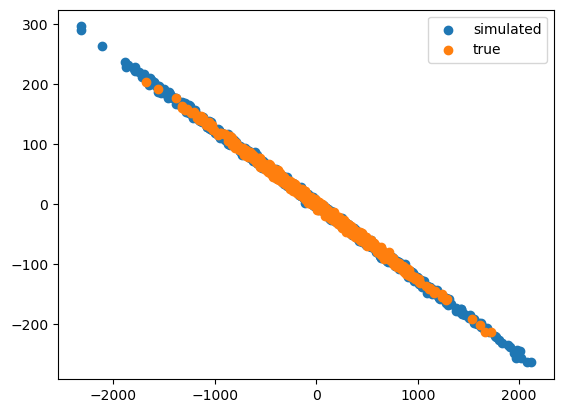

In [14]:
sde = sdes.LinearSchrodingerBridge(2,device)
print(sde.A.A.bias.data)
sde.A.A.requires_grad_(False)
sde.A.A.bias = nn.Parameter((torch.tensor([[ 0.9150,  0.8235],[-0.9749,  0.3197]],device=device)).reshape(-1))
sde.A.A.requires_grad_(False)

sde.A.to(device=device)
print(sde.A.A.bias.data)

x = torch.randn((1000,2),device=device)
steps = 150
times = torch.linspace(0,sde.T(),steps=steps, device=device)
dt = sde.T()/steps
for i in range(steps):
    ti = times[i].expand(x.shape[0],1)
    x = x + sde.drift(x,ti) * dt + sde.diffusion(x,ti) * torch.randn_like(x) * dt**.5

prior = sde.prior_sampling((1000,2),device)

# plt.xlim(-10,10)
# plt.ylim(-10,10)
plt.scatter(x[:,0].cpu().numpy(), x[:,1].cpu().numpy(), label='simulated')
plt.scatter(prior[:,0].cpu().numpy(), prior[:,1].cpu().numpy(),label='true')

plt.legend()
# plt.savefig(f'./trajectory/{i}.png')
# plt.close()
plt.show()

In [8]:
A = torch.tensor([[ 0.9150,  0.8235],[-0.9749,  0.3197]],device=device)
D = torch.eye(2,device=device) - 2  * (A + A.T)

print(D)
print(torch.linalg.eigh(D))
# print(sde.compute_variance(torch.tensor([[sde.T()]],device=device)))

tensor([[-2.660,  0.303],
        [ 0.303, -0.279]], device='cuda:0')
torch.return_types.linalg_eigh(
eigenvalues=tensor([-2.698, -0.241], device='cuda:0'),
eigenvectors=tensor([[ 0.992,  0.124],
        [-0.124,  0.992]], device='cuda:0'))
